# Libraries

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import random
import pickle
import cv2
import timm
import torch
import hdbscan

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import defaultdict
from torchvision import transforms
from PIL import Image, ImageFile

# Data

In [ ]:
training_data = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
testing_data = pd.read_csv('/kaggle/input/UBC-OCEAN/test.csv')

In [ ]:
# First, filter the DataFrame to include only rows where is_tma is True
tma_train_data = training_data[training_data['is_tma'] == True].copy()

# Then, add a new column 'path' that combines the specified path with the 'image_id'
tma_train_data['path'] = '/kaggle/input/UBC-OCEAN/train_images/' + tma_train_data['image_id'].astype(str) + '.png'

In [ ]:
# Assuming tma_train_data is your DataFrame
# If it's in a CSV file, use: tma_train_data = pd.read_csv('path_to_your_csv_file')

# Parameters for visualization
num_images = len(tma_train_data)
num_columns = 5
num_rows = 5  # For a 5x5 grid, assuming there are exactly 25 images
image_size = (100, 100)  # Resize dimensions, can be adjusted

# Create a figure for displaying images
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15), squeeze=False)

# Load, resize, and display each image along with its label and ID
for idx, (i, row) in enumerate(tma_train_data.iterrows()):
    img_path = row['path']
    label = row['label']
    image_id = row['image_id']

    # Calculate the position of the subplot
    row_idx = idx // num_columns
    col_idx = idx % num_columns

    img = Image.open(img_path)
    img = img.resize(image_size)

    ax = axes[row_idx, col_idx]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"ID: {image_id}, Label: {label}", fontsize=8)

# Hide any unused subplots
for ax in axes.flatten()[idx + 1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Extract feature vectors from TMA tiles

In [ ]:
combined_data = pd.read_csv('/kaggle/input/final-combined/final_combined_data.csv')

In [ ]:
# Increase the maximum number of pixels PIL can process
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load a pre-trained model for feature extraction
model = timm.create_model('resnet50', pretrained=True, num_classes=0)
model.eval()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
# Function to check if the tile has tissue present
def is_tissue_present(tile, area_threshold=0.3, low_saturation_threshold=20):
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to extract features from a tile
def extract_features(tile, model, transform):
    tile = Image.fromarray(tile)
    tile = transform(tile).unsqueeze(0)
    with torch.no_grad():
        features = model(tile)
    return features.squeeze(0).numpy()

# Define the size for the tiles
tile_size = 448

tma_train_features = {}

# Function to process a patch of the image
def process_patch(patch, model, transform):
    if is_tissue_present(patch):
        features = extract_features(patch, model, transform)
        return features
    return None

# Process each image, extract tiles, extract features, and store them
total_images = len(tma_train_data)
for index, row in enumerate(tma_train_data.iterrows()):
    image_path = row[1]['path']
    label = row[1]['label']
    tile_features = []  # List to hold the features for the current image

     # Print the current status
    print(f"Processing image {index + 1} of {total_images}: {image_path}")

    # Open the image using Pillow
    with Image.open(image_path) as img:
        for y in range(0, img.height, tile_size):
            for x in range(0, img.width, tile_size):
                # Read the patch
                patch = img.crop((x, y, x + tile_size, y + tile_size))
                patch = np.array(patch)  # Convert PIL Image to NumPy array

                # Process the patch
                features = process_patch(patch, model, transform)
                if features is not None:
                    tile_features.append(features)

    # Store the extracted features and the label in the tma_train_features dictionary
    tma_train_features[image_path] = {
        'features': tile_features,
        'label': label
    }

# Now tma_train_features contains the feature vectors and labels for all TMA images

In [ ]:
#Save features

with open('/kaggle/working/tma_features(resnet101).pkl', 'wb') as f:
    pickle.dump(tma_train_features, f)

In [1]:
#Load features

with open('/kaggle/input/tma-features-resnet101/tma_features(resnet101).pkl', 'rb') as f:
    tma_train_features = pickle.load(f)

----------------------------------------------------------

### Splitting data into train, validation and test sets

In [2]:
# Convert tma_train_features to a suitable format
data = [(features['features'], features['label']) for path, features in tma_train_features.items()]

# Organize data by labels
data_by_label = defaultdict(list)
for features, label in data:
    data_by_label[label].append((features, label))

# Split data for each label into train, validation, and test
train_data = []
val_data = []
test_data = []

for label, label_data in data_by_label.items():
    # Split data for this label into train and test
    train_val_label_data, test_label_data = train_test_split(label_data, test_size=0.2)
    
    # Split train data into train and validation
    train_label_data, val_label_data = train_test_split(train_val_label_data, test_size=0.25)  # 0.25 x 0.8 = 0.2 of original
    
    # Append split data to respective sets
    train_data.extend(train_label_data)
    val_data.extend(val_label_data)
    test_data.extend(test_label_data)

# Shuffle the datasets
random.shuffle(train_data)
random.shuffle(val_data)
random.shuffle(test_data)

# Function to check balance in each set
def check_balance(dataset):
    label_counts = defaultdict(int)
    for _, label in dataset:
        label_counts[label] += 1
    return dict(label_counts)

# Display balance of each set
print("Train balance:", check_balance(train_data))
print("Validation balance:", check_balance(val_data))
print("Test balance:", check_balance(test_data))

Train balance: {'LGSC': 3, 'MC': 3, 'CC': 3, 'HGSC': 3, 'EC': 3}
Validation balance: {'LGSC': 1, 'MC': 1, 'CC': 1, 'HGSC': 1, 'EC': 1}
Test balance: {'EC': 1, 'LGSC': 1, 'HGSC': 1, 'CC': 1, 'MC': 1}


--------------------------------


# Clustering

### Visualize clusters for training data TMA feature vectors 

In [5]:
train_features = []
train_labels = []

# Iterate over the training data to aggregate features and labels
for bag, label in train_data:
    for feature_vector in bag:
        train_features.append(feature_vector)
        train_labels.append(label)

# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [10]:
# t-SNE with adjusted parameters
tsne = TSNE(n_components=2, perplexity=30, learning_rate=500, n_iter=1000, metric='minkowski')
tsne_embedding_train = tsne.fit_transform(train_features)

# Adjusted HDBSCAN parameters
min_cluster_size = 2
min_samples = 10
epsilon = 0.12
alpha = 0.1

# Clustering with HDBSCAN
cluster_labels_train = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                       min_samples=min_samples, 
                                       cluster_selection_epsilon=epsilon,
                                       alpha=alpha, 
                                       gen_min_span_tree=True).fit_predict(tsne_embedding_train)

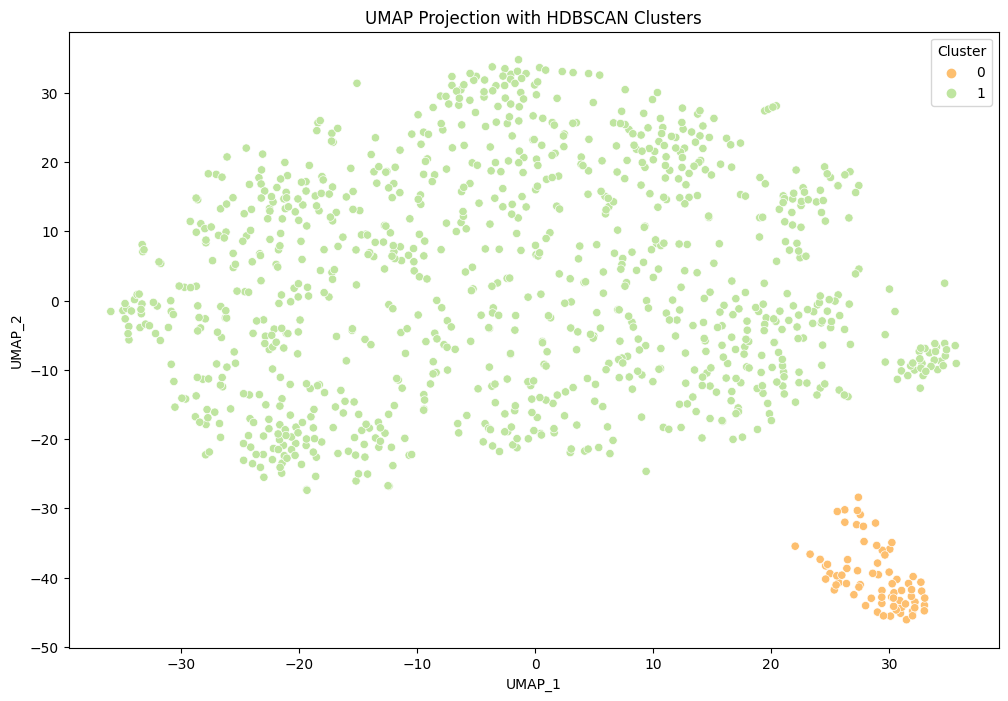

In [11]:
# Convert the UMAP embedding and cluster labels to a pandas DataFrame for plotting
embedding_df_train = pd.DataFrame(tsne_embedding_train, columns=['UMAP_1', 'UMAP_2'])
embedding_df_train['Cluster'] = cluster_labels_train

# Plot using Seaborn's scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=embedding_df_train, x='UMAP_1', y='UMAP_2', hue='Cluster', palette='Spectral')
plt.title("UMAP Projection with HDBSCAN Clusters")
plt.show()

### TMA features, when clustered can only recognize HGSC patterns.
Not enough for future usage of clustering for TMAs

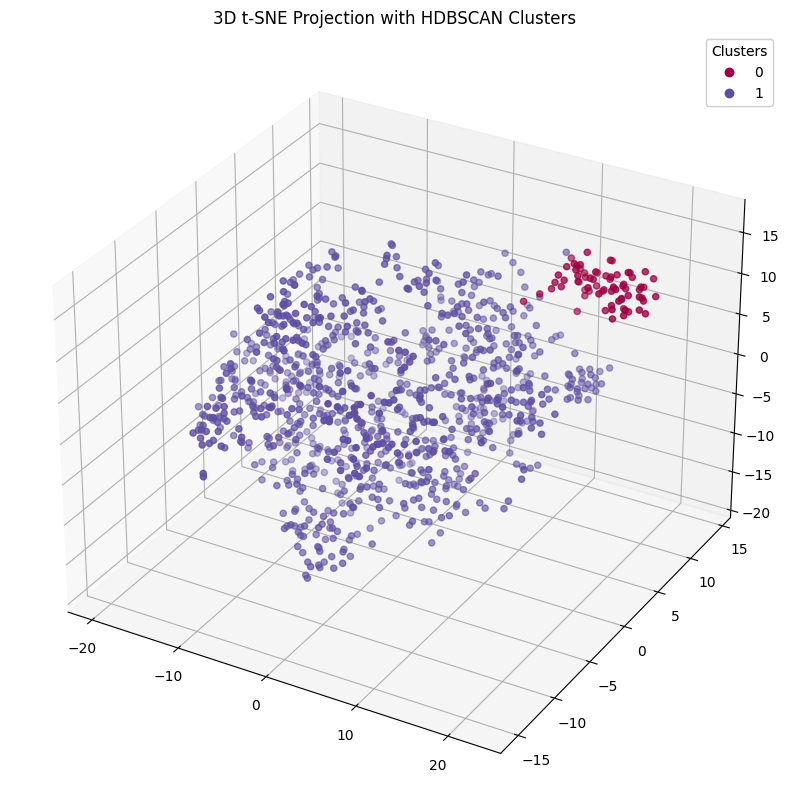

In [12]:
# Instantiate the 3D t-SNE object
tsne_3d = TSNE(n_components=3, perplexity=30, metric='minkowski')
tsne_embedding_train_3d = tsne_3d.fit_transform(train_features)

# Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_embedding_train_3d[:, 0], tsne_embedding_train_3d[:, 1], tsne_embedding_train_3d[:, 2], 
                     c=cluster_labels_train, cmap='Spectral')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title("3D t-SNE Projection with HDBSCAN Clusters")
plt.show()

Cluster 0 label distribution:
Original_Label
HGSC    72
Name: count, dtype: int64



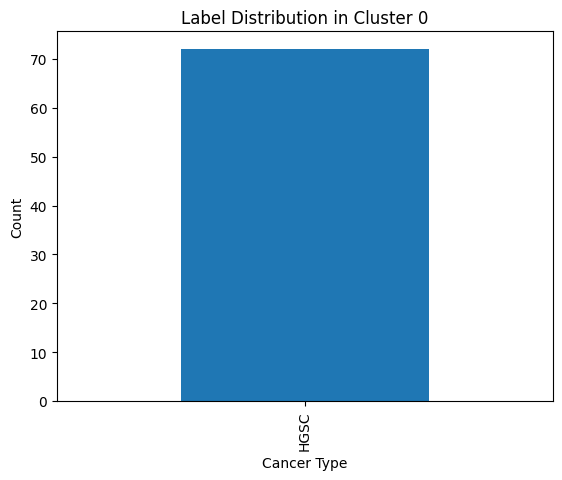

Cluster 1 label distribution:
Original_Label
CC      219
HGSC    207
LGSC    194
MC      184
EC      181
Name: count, dtype: int64



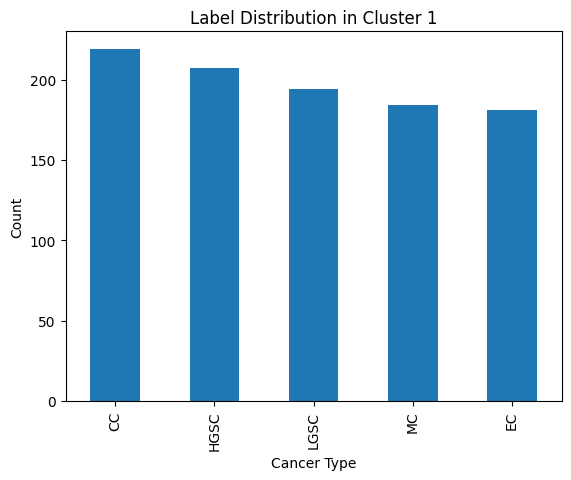

In [13]:
# Create a DataFrame with UMAP embeddings, HDBSCAN cluster labels, and original labels
embedding_df_train['Original_Label'] = train_labels

# Analyze the labels for each cluster
for cluster in range(0, 2):  # Assuming clusters are numbered 0 to 4
    cluster_data_train = embedding_df_train[embedding_df_train['Cluster'] == cluster]
    label_counts = cluster_data_train['Original_Label'].value_counts()
    print(f"Cluster {cluster} label distribution:\n{label_counts}\n")

    # Optionally, create a bar plot for each cluster's label distribution
    label_counts.plot(kind='bar')
    plt.title(f"Label Distribution in Cluster {cluster}")
    plt.xlabel("Cancer Type")
    plt.ylabel("Count")
    plt.show()